In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

In [15]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim import lr_scheduler
from torchinfo import summary
from tqdm.auto import tqdm

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load data
data_dir = "/kaggle/input/chest-ctscan-images/Data"
train_data = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
test_data = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=data_transform)
validation_data = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=data_transform)

class_names = train_data.classes
class_names
class_dict = train_data.class_to_idx
class_dict

# Change the key
old_key1 = 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new_key1 = 'adenocarcinoma_left.lower.lobe'

old_key2 = 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new_key2 = 'large.cell.carcinoma_left.hilum'

old_key3 = 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new_key3 = 'squamous.cell.carcinoma_left.hilum'

# Step 1: Add new key-value pair
class_dict[new_key1] = class_dict[old_key1]
class_dict[new_key2] = class_dict[old_key2]
class_dict[new_key3] = class_dict[old_key3]


# Step 2: Remove old key-value pair
del class_dict[old_key1]
del class_dict[old_key2]
del class_dict[old_key3]


print(class_dict)

class_names[0]=new_key1
class_names[1]=new_key2
class_names[3]=new_key3
class_names


# Dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model setup
resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model.parameters():
    param.requires_grad = True

resnet18_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, len(class_names))
)

resnet18_model.to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Model summary
summary(resnet18_model, input_size=(1, 3, 224, 224))

# Training and evaluation functions
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (y_pred.argmax(1) == y).sum().item() / len(y)

    return total_loss / len(dataloader), total_acc / len(dataloader)

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            total_loss += loss.item()
            total_acc += (y_pred.argmax(1) == y).sum().item() / len(y)

    return total_loss / len(dataloader), total_acc / len(dataloader)

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# Train model
NUM_EPOCHS = 15
start_time = timer()
model_0_results = train(resnet18_model, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS, device)
end_time = timer()

print(f"Total training time: {end_time - start_time:.2f} seconds")
print(f"Final train loss: {model_0_results['train_loss'][-1]:.4f}, train acc: {model_0_results['train_acc'][-1]:.4f}")
print(f"Final test loss: {model_0_results['test_loss'][-1]:.4f}, test acc: {model_0_results['test_acc'][-1]:.4f}")


{'normal': 2, 'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'squamous.cell.carcinoma_left.hilum': 3}


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train loss: 1.2625 | Train acc: 0.4331 | Test loss: 1.0605 | Test acc: 0.5538
Epoch 2/15 | Train loss: 0.8523 | Train acc: 0.6438 | Test loss: 1.0333 | Test acc: 0.4980
Epoch 3/15 | Train loss: 0.5629 | Train acc: 0.7625 | Test loss: 0.9753 | Test acc: 0.5617
Epoch 4/15 | Train loss: 0.3263 | Train acc: 0.8594 | Test loss: 5.0515 | Test acc: 0.1906
Epoch 5/15 | Train loss: 0.3328 | Train acc: 0.8766 | Test loss: 1.7354 | Test acc: 0.4074
Epoch 6/15 | Train loss: 0.2023 | Train acc: 0.9344 | Test loss: 0.6515 | Test acc: 0.7622
Epoch 7/15 | Train loss: 0.2340 | Train acc: 0.9300 | Test loss: 0.8294 | Test acc: 0.7206
Epoch 8/15 | Train loss: 0.1129 | Train acc: 0.9656 | Test loss: 0.7343 | Test acc: 0.7458
Epoch 9/15 | Train loss: 0.0564 | Train acc: 0.9875 | Test loss: 0.6401 | Test acc: 0.7806
Epoch 10/15 | Train loss: 0.0316 | Train acc: 0.9922 | Test loss: 0.6287 | Test acc: 0.7712
Epoch 11/15 | Train loss: 0.0258 | Train acc: 0.9969 | Test loss: 0.4823 | Test acc: 0.81

In [18]:
torch.save(resnet18_model.state_dict(), "resnet18_chestct.pth")


Image permute: torch.Size([224, 224, 3]) 


Text(0.5, 1.0, 'adenocarcinoma_left.lower.lobe')

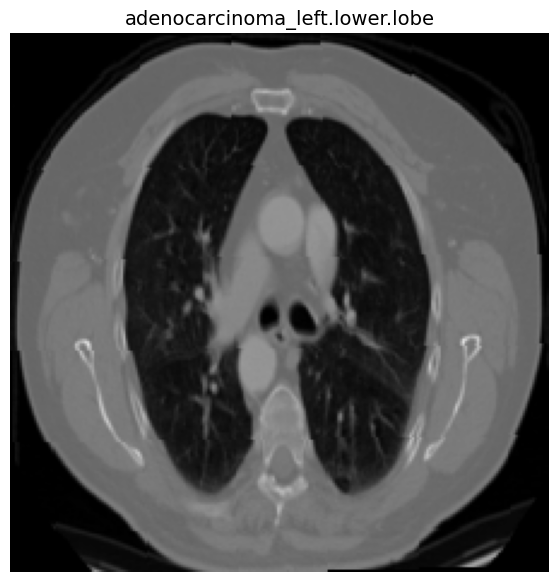

In [19]:
import random 
from PIL import Image
import matplotlib.pyplot as plt
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]


img_permute = img.permute(1, 2, 0)
print(f"Image permute: {img_permute.shape} ")
plt.figure(figsize=(12, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [20]:
torch.save(resnet18_model.state_dict(), "resnet18_chestct.pth")
